In [ ]:
# !wget http://images.cocodataset.org/zips/val2017.zip
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# !mkdir coco_dataset
# !mv val2017.zip coco_dataset
# !mv annotations_trainval2017.zip coco_dataset
# !cd coco_dataset && unzip val2017.zip
# !cd coco_dataset && unzip annotations_trainval2017.zip

In [1]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2

## For visualizing results
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
%matplotlib inline

In [2]:
dataDir='./coco_dataset'
dataType='val'
annFile='{}/annotations/instances_{}2017.json'.format(dataDir,dataType)

# initialize the COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!


In [3]:
# display COCO categories and supercategories
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

nms=[cat['name'] for cat in cats]
print(len(nms),'COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print(len(nms),'COCO supercategories: \n{}'.format(' '.join(nms)))

80 COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

12 COCO supercategories: 
person appliance furniture outdoor indoor animal accessory food electronic vehicle kitchen sports


In [4]:
from collections import Counter

# get all images containing given categories, select one at random
# filter classes to the pascal voc dataset
filterClasses = ['person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'airplane', 'bicycle', 'boat', 'bus', 'car', 'motorcycle', 'train', 'bottle', 'chair', 'dining table', 'potted plant', 'couch', 'tv']
imgIds = []
catIds = []
for i in filterClasses:
    filter = coco.getCatIds(catNms=[i])
    catIds.extend(filter)
    imgIds.extend(coco.getImgIds(catIds=filter))

    print("Number of images containing all required classes:", i, len(imgIds))

imgIds = list(set(imgIds))
cats = coco.loadCats(catIds)


Number of images containing all required classes: person 2693
Number of images containing all required classes: bird 2818
Number of images containing all required classes: cat 3002
Number of images containing all required classes: cow 3089
Number of images containing all required classes: dog 3266
Number of images containing all required classes: horse 3394
Number of images containing all required classes: sheep 3459
Number of images containing all required classes: airplane 3556
Number of images containing all required classes: bicycle 3705
Number of images containing all required classes: boat 3826
Number of images containing all required classes: bus 4015
Number of images containing all required classes: car 4550
Number of images containing all required classes: motorcycle 4709
Number of images containing all required classes: train 4866
Number of images containing all required classes: bottle 5245
Number of images containing all required classes: chair 5825
Number of images contain

In [6]:
from torch.utils.data import Dataset

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

class_dict = {  'background': 0,
                'airplane': 1,
                'bicycle': 2,
                'bird': 3,
                'boat': 4,
                'bottle': 5,
                'bus': 6,
                'car': 7,
                'cat': 8,
                'chair': 9,
                'cow': 10,
                'dining table': 11,
                'dog': 12,
                'horse': 13,
                'motorcycle': 14,
                'person': 15,
                'potted plant': 16,
                'sheep': 17,
                'couch': 18,
                'train': 19,
                'tv': 20}


class CocoDataset(Dataset):

    def __init__(self, coco, 
                 imgIds, 
                 cats, 
                 class_dict, 
                 dataType, 
                 dataDir, 
                 img_transform=None,
                 mask_transform=None):
        self.coco = coco
        self.imgIds = imgIds
        self.cats = cats
        self.class_dict = class_dict
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.dataType = dataType
        self.dataDir = dataDir

    def __len__(self):
        return len(self.imgIds)
    
    def __getitem__(self, idx):
        img = self.coco.loadImgs(self.imgIds[idx])[0]
        annIds = self.coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
        anns = self.coco.loadAnns(annIds)
        image = Image.open(os.path.join(self.dataDir, self.dataType + '2017', img['file_name']))
        mask = np.zeros((img['height'],img['width']))
        ints_to_str = {}
        for i in range(len(anns)):
            className = getClassName(anns[i]['category_id'], self.cats)
            if className in self.class_dict:
                pixel_value = self.class_dict[className]
                mask = np.maximum(self.coco.annToMask(anns[i])*pixel_value, mask)
                ints_to_str[pixel_value] = className
        unnormalized_image = np.array(image.resize((640, 640)))
        if self.img_transform:
            image = self.img_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        sample = {'image': image, 'mask': mask, 'ints_to_str': ints_to_str, 'unnormalized_image': unnormalized_image}
        return sample
    
dataset = CocoDataset(coco, imgIds, cats, class_dict, dataType, dataDir)

In [7]:
img = coco.loadImgs(imgIds[19])[0]
annIds = coco.getAnnIds(imgIds=img["id"], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)

In [8]:
img2 = coco.loadImgs(imgIds[19])[0]
I = io.imread('{}/{}2017/{}'.format(dataDir,dataType,img2['file_name']))/255.0

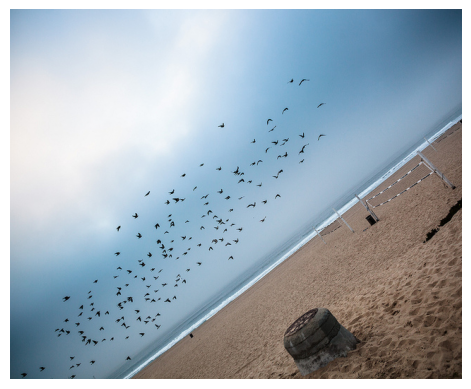

In [10]:
plt.axis('off')
plt.imshow(I)
plt.show()

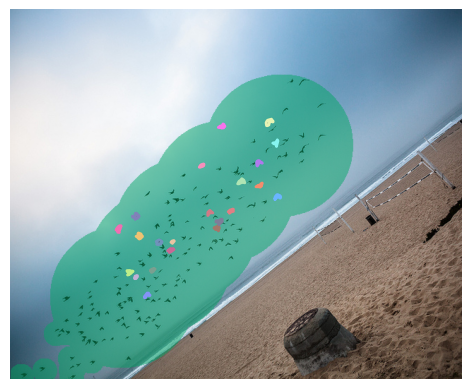

In [11]:
plt.imshow(I); plt.axis('off')
coco.showAnns(anns)

In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

class expand_gray_channel(object):
    def __call__(self, tensor):
        if tensor.shape[0] == 1:
            return tensor.expand(3, -1, -1)
        return tensor

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((640, 640), interpolation=Image.NEAREST),
    expand_gray_channel(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
mask_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((640, 640), interpolation=Image.NEAREST),
])

import dataquality as dq
from dataquality.integrations.torch import watch as semseg_torch_watch
dq.login()

dq.init("semantic_segmentation", "Derek-Elliott-Proj", "First-Test")

# dq.log_image_paths("images", [os.path.join(dataDir, dataType + '2017', img['file_name']) for img in coco.loadImgs(imgIds)])

dataset = CocoDataset(coco, imgIds, cats, class_dict, dataType, dataDir, img_transform=img_transforms, mask_transform=mask_transforms)
train_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

semseg_torch_watch(model)

model.eval()
criterion = torch.nn.CrossEntropyLoss()


/var/folders/pd/6x8lc6xj7w74_4vxq68yz2gm0000gn/T/ipykernel_55124/4072454559.py:13: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  transforms.Resize((640, 640), interpolation=Image.NEAREST),
/var/folders/pd/6x8lc6xj7w74_4vxq68yz2gm0000gn/T/ipykernel_55124/4072454559.py:19: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  transforms.Resize((640, 640), interpolation=Image.NEAREST),
Using cache found in /Users/elliottchartock/.cache/torch/hub/pytorch_vision_v0.10.0


tensor(0.0621, grad_fn=<NllLossBackward0>)
{12: ['dog']}


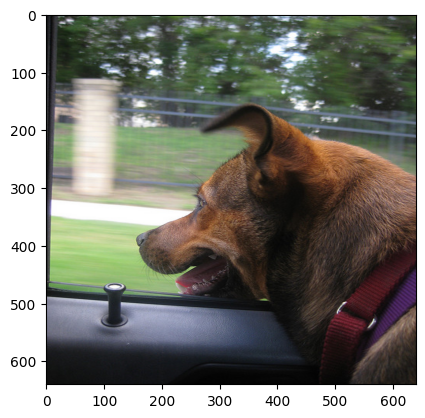

[ 0. 12.]


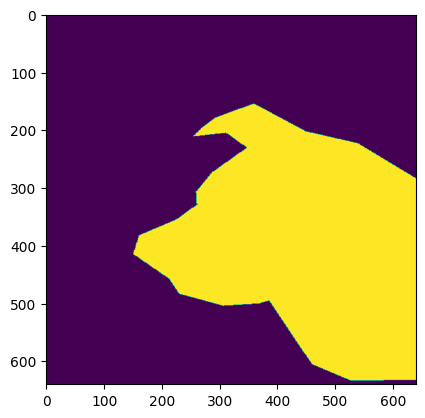

array([ 0, 12])

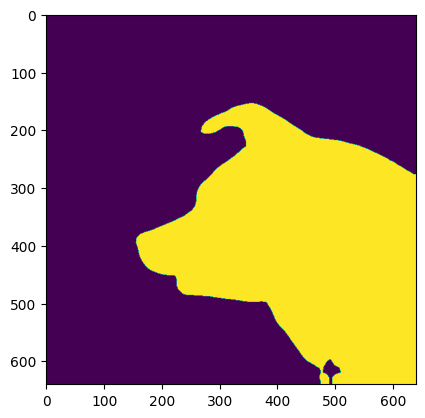

In [363]:
for i, sample in enumerate(train_loader):
    imgs, masks = sample['image'], sample['mask']
    out = model(imgs)
    # reshape to have loss for each pixel
    out = out['out'].permute(0, 2, 3, 1).contiguous().view(-1, 21)
    masks = masks.long().view(-1)
    loss = criterion(out, masks)
    print(loss)
    break
print(sample['ints_to_str'])
image = sample['unnormalized_image'][0] / 255
plt.imshow(image)
plt.show()
mask = sample['mask'][0].permute(1, 2, 0)
plt.imshow(mask)
print(np.unique(mask))
plt.show()
pred = out.argmax(1).view(640, 640).detach().numpy()
plt.imshow(pred)
np.unique(pred)


In [339]:
pred.shape

(640, 640)

In [340]:
import cv2 as cv


In [341]:
pred_blackwhite = pred.copy()

In [342]:
pred_blackwhite = pred_blackwhite.astype(np.uint8)

In [343]:
pred_blackwhite.shape

(640, 640)

In [344]:
# Get unique values in numpy
np.unique(pred_blackwhite)

array([ 0, 15], dtype=uint8)

In [345]:
# Set all values to 255 if equal to 7 otherwise 0
pred_blackwhite[pred_blackwhite != 15] = 0
pred_blackwhite[pred_blackwhite == 15] = 255

In [346]:
np.unique(pred_blackwhite)

array([  0, 255], dtype=uint8)

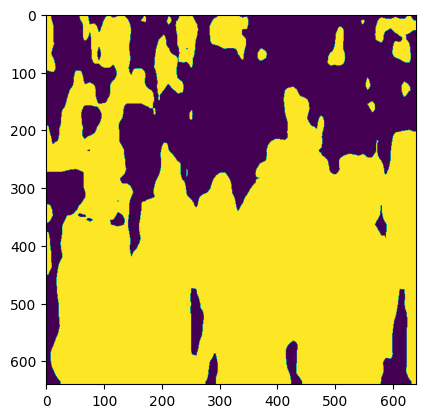

In [347]:
plt.imshow(pred_blackwhite)

In [348]:
contours, hierarchy = cv.findContours(pred_blackwhite, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [349]:
all_black = pred_blackwhite.copy()
all_black[all_black != 0] = 0

In [352]:
img_copy = image.numpy().copy()
imgwc = cv.drawContours(img_copy, contours, -1, (255, 0, 0), -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


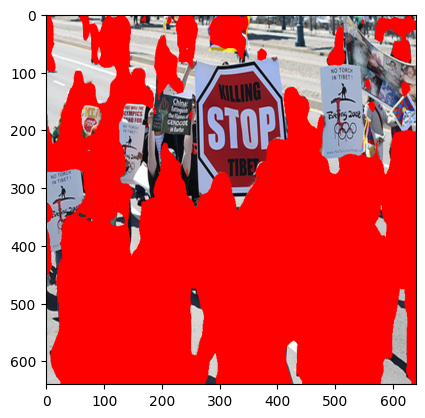

In [353]:
plt.imshow(imgwc)

In [354]:
len(contours)

28

In [378]:
type(contours[0].squeeze(1).tolist()[0][0])

int

In [382]:
list(map(tuple, contours[0].squeeze(1).tolist()))

[(0, 377),
 (0, 450),
 (3, 450),
 (4, 449),
 (4, 447),
 (5, 446),
 (5, 445),
 (6, 444),
 (6, 443),
 (7, 442),
 (7, 441),
 (8, 440),
 (8, 439),
 (9, 438),
 (9, 430),
 (8, 429),
 (8, 409),
 (7, 408),
 (7, 401),
 (6, 400),
 (6, 388),
 (5, 387),
 (5, 382),
 (4, 381),
 (4, 378),
 (3, 377)]